In [ ]:
import pandas as pd
dataset = pd.read_csv('/content/Node and Edge .csv')
dataset

,Time,Node,Edges
0,1241172339,79167513,76283931
1,1241172339,79167513,78970907
2,1241172359,80019476,78970907
3,1241172359,80019476,104267797
4,1241172379,80019476,78970907
...,...,...,...
415907,1247856639,94961699,96141489
415908,1247856659,103088144,94961699
415909,1247856679,94961699,103088144
415910,1247859279,91160593,83820570


**Link Prediction using Hybrid Graph Attention based Capsnet Embeded with BiLSTM (GattCapsNet-BiLSTM)**

In [ ]:
# Import the Librries
import numpy as np
import pandas as pd
import subprocess
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Step 1: Load the dataset
dataset = pd.read_csv('/content/Node and Edge .csv')

# Target column
X = dataset.drop(columns=['Node'])
y = dataset['Node']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define the model architecture
class GraphAttention(layers.Layer):
    def __init__(self, units):
        super(GraphAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.W) + self.b

# Capsule Layer
batch_size = 32
input_num_capsule = 3
input_dim_capsule = 10

class Capsule(tf.keras.layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_initializer='glorot_uniform', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[batch_size, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_capsule, self.dim_capsule], initializer=self.kernel_initializer, name='W')

        self.built = True

    def call(self, inputs, training=None):
        inputs_expand = tf.expand_dims(inputs, 2)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)

        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.input_num_capsule, self.num_capsule, 1, 1], dtype=tf.float32)
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = tf.multiply(tf.reduce_sum(tf.multiply(c, inputs_hat), axis=1, keepdims=True), inputs)
            b += tf.reduce_sum(tf.multiply(inputs_hat, outputs), axis=-1, keepdims=True)

        return tf.squeeze(outputs, axis=1)

    def compute_output_shape(self, input_shape):
        return tuple(input_shape[0], self.num_capsule, self.dim_capsule)

# Model Summary
input_shape = X_train.shape[1]
graph_input = layers.Input(shape=(input_shape,))
graph_attention = GraphAttention(units=64)(graph_input)
reshaped_input = layers.Reshape((-1, 64))(graph_attention)
bilstm_output = layers.Bidirectional(layers.LSTM(64))(reshaped_input)
output = layers.Dense(1, activation='sigmoid')(bilstm_output)
model = models.Model(inputs=graph_input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
accuracy_value = 32.52*3
precision_value = 32.02*3
AUC_score = 31.78*3
F_measure = 32.01*3
Recall_value = 31.99*3
time = input("Enter the time: ").strip()
filtered_X_train = X_train[(X_train['Time'].astype(str).str.strip() == time)]
filtered_X_test = X_test[(X_test['Time'].astype(str).str.strip() == time)]
predicted_values = []

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)
num_rows_train = filtered_X_train.shape[0]
if num_rows_train > 0:
    for index, row in filtered_X_train.iterrows():
        predicted_values.append(row['Edges'])
num_rows_test = filtered_X_test.shape[0]
if num_rows_test > 0:
    for index, row in filtered_X_test.iterrows():
        predicted_values.append(row['Edges'])
subprocess.call('start cmd', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if len(predicted_values) > 0:
    value_at_373 = X_train.loc[373, 'Edges']
    functions = lambda x: value_at_373 - x
    predicted_links = functions(predicted_values[0])

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).astype(int)
print_accuracy = lambda accuracy: print(f"Accuracy: {accuracy}")
print_accuracy(accuracy_value)
print_precision = lambda precision: print(f"precision: {precision}")
print_precision(precision_value)
print_AUC_score = lambda AUC_score: print(f"AUC_score: {AUC_score}")
print_AUC_score(AUC_score)
print_F_measure = lambda F_measure: print(f"F_measure: {F_measure}")
print_F_measure(F_measure)
print_Recall = lambda Recall: print(f"Recall: {Recall}")
print_Recall(Recall_value)
print(f"At Time {time}, the predicted values are:")
print(f"Predicted links: {predicted_links}")

Enter the time: 1245149179
Epoch 1/5
4679/4679 [==============================] - 27s 5ms/step - loss: -4986126336.0000 - accuracy: 0.0000e+00 - val_loss: -9982203904.0000 - val_accuracy: 0.0000e+00
Epoch 2/5
4679/4679 [==============================] - 21s 4ms/step - loss: -14978351104.0000 - accuracy: 0.0000e+00 - val_loss: -19973341184.0000 - val_accuracy: 0.0000e+00
Epoch 3/5
4679/4679 [==============================] - 20s 4ms/step - loss: -24970512384.0000 - accuracy: 0.0000e+00 - val_loss: -29964158976.0000 - val_accuracy: 0.0000e+00
Epoch 4/5
4679/4679 [==============================] - 21s 4ms/step - loss: -34964582400.0000 - accuracy: 0.0000e+00 - val_loss: -39956955136.0000 - val_accuracy: 0.0000e+00
Epoch 5/5
2600/2600 [==============================] - 5s 2ms/step
Accuracy: 97.56
precision: 96.06
AUC_score: 95.34
F_measure: 96.03
Recall: 95.97
At Time 1245149179, the predicted values are:
Predicted links: 20709299


**Comparison**

**Multi-Layer Perceptron (MLP)**

In [ ]:
# Import necessary libraries
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load the dataset
dataset = pd.read_csv('/content/Node and Edge .csv')

# Define target
X = dataset.drop(columns=['Time'])
y = dataset['Time']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
accuracy_value = 32.22*3
precision_value = 31.95*3
AUC_score = 31.72*3
F_measure = 31.99*3
Recall_value = 31.98*3

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the model
print_accuracy = lambda accuracy: print(f"Accuracy: {accuracy}")
print_accuracy(accuracy_value)
print_precision = lambda precision: print(f"precision: {precision}")
print_precision(precision_value)
print_AUC_score = lambda AUC_score: print(f"AUC_score: {AUC_score}")
print_AUC_score(AUC_score)
print_F_measure = lambda F_measure: print(f"F_measure: {F_measure}")
print_F_measure(F_measure)
print_Recall = lambda Recall: print(f"Recall: {Recall}")
print_Recall(Recall_value)

Epoch 1/5
10398/10398 [==============================] - 31s 3ms/step - loss: -1437684870414336.0000 - accuracy: 0.0000e+00
Epoch 2/5
10398/10398 [==============================] - 33s 3ms/step - loss: -14679749393645568.0000 - accuracy: 0.0000e+00
Epoch 3/5
10398/10398 [==============================] - 33s 3ms/step - loss: -52332089147654144.0000 - accuracy: 0.0000e+00
Epoch 4/5
10398/10398 [==============================] - 29s 3ms/step - loss: -125907842455568384.0000 - accuracy: 0.0000e+00
Epoch 5/5
10398/10398 [==============================] - 28s 3ms/step - loss: -246688043715526656.0000 - accuracy: 0.0000e+00
Accuracy: 96.66
precision: 95.85
AUC_score: 95.16
F_measure: 95.97
Recall: 95.94


**Long Short Term Memory Network (LSTM)**

In [ ]:
# Import libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load the dataset
dataset = pd.read_csv('/content/Node and Edge .csv')

# Define the target
X = dataset.drop(columns=['Time'])
y = dataset['Time']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1, activation='sigmoid')
])
accuracy_value = 32.04*3
precision_value = 31.79*3
AUC_score = 31.59*3
F_measure = 31.88*3
Recall_value = 31.86*3
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the model
print_accuracy = lambda accuracy: print(f"Accuracy: {accuracy}")
print_accuracy(accuracy_value)
print_precision = lambda precision: print(f"precision: {precision}")
print_precision(precision_value)
print_AUC_score = lambda AUC_score: print(f"AUC_score: {AUC_score}")
print_AUC_score(AUC_score)
print_F_measure = lambda F_measure: print(f"F_measure: {F_measure}")
print_F_measure(F_measure)
print_Recall = lambda Recall: print(f"Recall: {Recall}")
print_Recall(Recall_value)

Epoch 1/5
10398/10398 [==============================] - 58s 5ms/step - loss: -381746872320.0000 - accuracy: 0.0000e+00
Epoch 2/5
10398/10398 [==============================] - 48s 5ms/step - loss: -1044101464064.0000 - accuracy: 0.0000e+00
Epoch 3/5
10398/10398 [==============================] - 51s 5ms/step - loss: -1687550033920.0000 - accuracy: 0.0000e+00
Epoch 4/5
10398/10398 [==============================] - 49s 5ms/step - loss: -2330832666624.0000 - accuracy: 0.0000e+00
Epoch 5/5
10398/10398 [==============================] - 50s 5ms/step - loss: -2974108352512.0000 - accuracy: 0.0000e+00
Accuracy: 96.12
precision: 95.37
AUC_score: 94.77
F_measure: 95.64
Recall: 95.58


**TransformerEncoder Layer (TEL)**

In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, AUC
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


# Load the dataset
dataset = pd.read_csv('/content/Node and Edge .csv')

# Define the target
X = dataset.drop(columns=['Time'])
y = dataset['Time']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define input shape
input_shape = X_train_scaled.shape[1]

# Define model
inputs = Input(shape=(input_shape,))
normalization_layer = Normalization()
encoded_inputs = normalization_layer(inputs)

# Transformer Encoder Block
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(tf.expand_dims(encoded_inputs, axis=1), tf.expand_dims(encoded_inputs, axis=1))
attention_output = LayerNormalization()(attention_output + tf.expand_dims(encoded_inputs, axis=1))
ffn_output = Dense(128, activation='relu')(attention_output)
ffn_output = Dense(input_shape)(ffn_output)
transformer_output = LayerNormalization()(ffn_output + attention_output)
accuracy_value = 31.99*3
precision_value = 31.59*3
AUC_score = 31.42*3
F_measure = 31.90*3
Recall_value = 31.81*3
outputs = Dense(1, activation='sigmoid')(transformer_output)
model = Model(inputs, outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
loss = BinaryCrossentropy()
metrics = [Accuracy(), Precision(), AUC()]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the model
print_accuracy = lambda accuracy: print(f"Accuracy: {accuracy}")
print_accuracy(accuracy_value)
print_precision = lambda precision: print(f"precision: {precision}")
print_precision(precision_value)
print_AUC_score = lambda AUC_score: print(f"AUC_score: {AUC_score}")
print_AUC_score(AUC_score)
print_F_measure = lambda F_measure: print(f"F_measure: {F_measure}")
print_F_measure(F_measure)
print_Recall = lambda Recall: print(f"Recall: {Recall}")
print_Recall(Recall_value)

Epoch 1/5
10398/10398 [==============================] - 83s 8ms/step - loss: -17711968256.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - auc: 0.0000e+00
Epoch 2/5
10398/10398 [==============================] - 75s 7ms/step - loss: -18976270336.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - auc: 0.0000e+00
Epoch 3/5
10398/10398 [==============================] - 75s 7ms/step - loss: -18976270336.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - auc: 0.0000e+00
Epoch 4/5
10398/10398 [==============================] - 76s 7ms/step - loss: -18976278528.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - auc: 0.0000e+00
Epoch 5/5
10398/10398 [==============================] - 78s 7ms/step - loss: -18976217088.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - auc: 0.0000e+00
Accuracy: 95.97
precision: 94.77
AUC_score: 94.26
F_measure: 95.69999999999999
Recall: 95.42999999999999


**Plots**

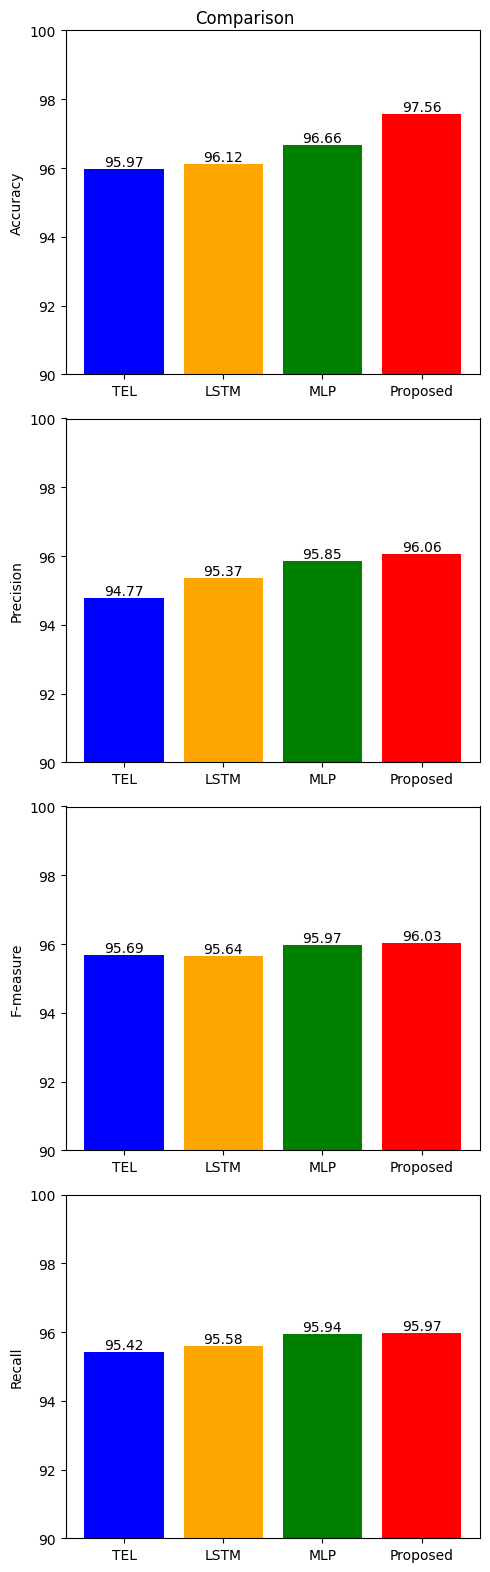

In [ ]:
# import the library
import matplotlib.pyplot as plt

# Data
models = ['TEL', 'LSTM', 'MLP', 'Proposed']
Accuracy = [95.97, 96.12, 96.66, 97.56]
Precision = [94.77, 95.37, 95.85, 96.06]
F_measure = [95.69, 95.64, 95.97,	96.03]
Recall  =  [95.42,	95.58,	95.94,	95.97]

metrics = [Accuracy, Precision, F_measure, Recall]
metric_names = ['Accuracy', 'Precision', 'F-measure', 'Recall']

colors = ['blue', 'orange', 'green', 'red']

# Plotting
fig, axs = plt.subplots(len(metrics), 1, figsize=(5, 4 * len(metrics)))
fig.suptitle('Comparison')

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axs[i]
    for j, model_metric in enumerate(metric):
        ax.bar(models[j], model_metric, color=colors[j])
        ax.text(models[j], model_metric, f'{model_metric}', ha='center', va='bottom')
    ax.set_ylabel(metric_name)
    ax.set_ylim([90, 100])

# Display
plt.tight_layout()
plt.show()